# Simulated elections for single seats-votes curves

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

Now that we have learned more about how seats-votes curves are constructed in a single election, we can deal a bit more on how we can model the fact that elections have a fundamental level of *uncertainty* about their outcomes. Although the election we did observe has a specific, known result, there are many minor ways things could have gone differently and changed the result of the election. In general, these kinds of random processes are fundamentally *random*, in that there are some components of them that are nearly impossible to model directly. The accumulated impacts of small choices about folks choosing to vote or not vote, invalid or mis-marked ballots... they all add up to result in elections being somewhat intrinsically difficult to model directly. 

Thus, models of the seats-votes curve also aim to represent this uncertainty in the estimates of the curve. Given the techniques discussed in *The Seats-Votes Curve in a Single Election*, we can begin to examine what happens when we construct an estimate of the seats-votes curve that reflects this intrinsic variation. Below, I'll show a strategy related to the discussion from Nagle (2018), but using a much simpler method of building a seats-votes curve. 

First, though, we'll have to read in the data again:

In [1]:
import seatsvotes
import numpy
import geopandas
import seaborn
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
df = seatsvotes.data.congress(geo=True)

Then, we'll focus in on California, a state with many districts (53) and an interesting structure to its seats-votes curve in the 2000s. 

In [3]:
ca = df[df.state_name.str.match('california')]

The data that we have is fairly conventional, containing information on turnout (raw votes cast), the year in which the election was held, as well as information on the district shape and many other pieces of information about the district itself:

In [4]:
ca.head()

,index,congress,year,delsouth,state_fips,contest_ui,inc,king_dist,lewis_dist,state_name,turnout,vote_share,geom_uid,geometry
0,870,107,2000,0,06,107006026,1,NaN,26,california,96500.0,1.000000,006103107026,"POLYGON ((-118.507462 34.334783, -118.503818 3..."
1,871,107,2000,0,06,107006029,1,NaN,29,california,226079.0,0.797487,006103107029,"POLYGON ((-118.354011 34.16120600000001, -118...."
2,872,107,2000,0,06,107006030,1,NaN,30,california,95011.0,0.875930,006103107030,"POLYGON ((-118.183977 34.14920299999997, -118...."
12,882,107,2000,0,06,107006031,0,NaN,31,california,89600.0,1.000000,006103107031,"POLYGON ((-117.941747 34.16522799999998, -117...."
13,883,107,2000,0,06,107006032,1,NaN,32,california,157371.0,0.873395,006103107032,"POLYGON ((-118.37231 34.06421, -118.34631 34.0..."


This data has results from many different election years:

In [5]:
ca.sort_values('year').year.unique()

array([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010])

For this data, we'll use a method based on the [*bootstrap*](https://en.wikipedia.org/wiki/Bootstrapping_(statistics) to build very basic uncertainty into our estimates of the seats-votes curve. We'll explain how this bootstrapping works later in the notebook, but for now we'll just create the instance of the estimator object. 

In [6]:
svca = seatsvotes.Bootstrap(ca, district_id='lewis_dist')

/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/utils.py:143: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


And, for convenience, we'll focus on 2008. 

In [7]:
ca08 = svca.wide[-2]

Before we proceed, we need to discuss a more general idea of *swing*, the change in vote shares from year to year or between two different electoral scenarios in a given year. This change in vote outcomes between two elections is called the "swing" between elections, in a similar fashion to how we discussed *swing* within an election being a change in vote shares applied to each district. Thus, in general, a *swing* is a change in vote shares from one value to another value, kind of like how a *lag* is used in the analysis of time series data to refer to a previous time period's data and the *diff*/*difference* is the difference between the current and the previous time periods. The *swing* is the difference between two vote share vectors. 

Below is the structure of vote shares between 2006 and 2008 in California. If the swing were *uniform* like we've discussed before, then we'd expect to see all observations lying exactly on a line. However, because there are random fluctuations and deviations from evenness, this does not happen:

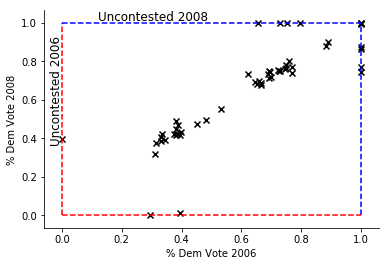

In [8]:
plt.scatter(ca08.vote_share__prev, ca08.vote_share, 
            marker='x', color='k')
plt.vlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.hlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.annotate('Uncontested 2006', 
             (-.04,.88), rotation=90, 
             fontsize=12)
plt.annotate('Uncontested 2008', 
             (.12,1.01), rotation=0, 
             fontsize=12)
seaborn.despine(ax=plt.gca())
plt.xlabel('% Dem Vote 2006')
plt.ylabel('% Dem Vote 2008')
plt.show()

Given the data from the `seatsvotes.Bootstrapper` object, we can also construct *exactly* the observed swing from 2006 to 2008:

In [9]:
ca08['swing'] = ca08.vote_share - ca08.vote_share__prev

And visualize its distribution below:

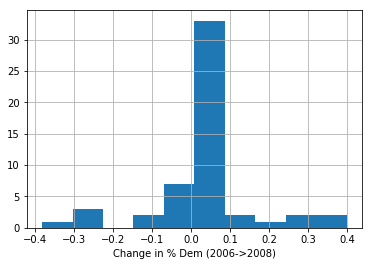

In [10]:
ca08['swing'].hist()
plt.xlabel("Change in % Dem (2006->2008)")
plt.show()

We see that most districts changed somewhere between +10% (district shifts by 10% towards the Democrats) and -10% (district shifts 10% towards the Republcians). But, we also see that, out in the tails, there appear to be two sets of districts with very large swings towards Democrats/Republicans. In general, these very large swings tend to be changes from districts that move from being contested to being uncontested. Uncontested districts are usually somewhere in the 80%-100% range for one candidate. So, as a district moves into or out of the very extreme values of vote shares (e. 90% Dem/Rep), then the swings associated with those changes tend to be very large. 

One method of naively constructing new elections using the data from past elections involves using *bootstrapping*. Bootstrapping works by re-sampling the observed data to construct a new, artificial dataset with similar (but not identical properties). Here, we can use bootstrapping on the electoral *swing* from 2006 to 2008. To do this, we first need to compute the swing between years, like we did above for `ca08['swing']`

$$\delta_i = v_{i, 2008} - v_{i, 2006}$$

Then, given that we've gotten $\delta_i$ for each district $i$ in a plan with $n$ districts, we *bootstrap* a new simulated value for the electoral outcome in 2008 in district $i$, $v_{i,2008}'$. The bootstrap picks some random district $j$, computes its swing $(\delta_j)$, and applies it to $v_{i,2006}$ to build $v_{i,2008}' = v_{i,2006} + \delta_j$. 

Below, we can look at what this looks like for a single election. We'll take the 2008 election in California, look at the change since 2006, and bootstrap from that change to make a new 'fake' 2008 election. We'll use use the `sample` function in `pandas` to shuffle the observed changes in vote around. 

Below, we'll first shuffle the swing, add it to the 2006 vote share, and then make sure that the final "fake" results for 2008 are still constrained to fall within 0 and 1.

In [11]:
shuffled_swing = ca08.swing.sample(frac=1, replace=True).values

fake_08 = ca08.vote_share__prev + shuffled_swing

fake_08 = numpy.clip(fake_08, 0,1)

ca08['alt_future'] = fake_08

Now that this is complete, we have randomly assigned the *swing, changes in district voteshare from 2006 to 2008,* back to districts in 2006. When adding the observed 2006 vote share and the now randomly-shuffled change, we get a new, "fake" 2008 vote share, but one with similar properties to the "real" observed 2008 vote share. 

To show how similar these elections would be}, we can plot the "fake" and "real" elections alongside one another, just like we did before: 

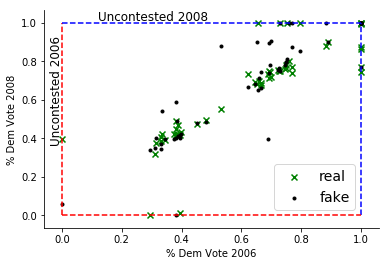

In [12]:
plt.scatter(ca08.vote_share__prev, ca08.vote_share, 
            marker='x', color='green', label='real')
plt.scatter(ca08.vote_share__prev, ca08.alt_future, 
            marker='.', color='k', label='fake')
plt.vlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.hlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.annotate('Uncontested 2006', 
             (-.04,.88), rotation=90, 
             fontsize=12)
plt.annotate('Uncontested 2008', 
             (.12,1.01), rotation=0, 
             fontsize=12)
plt.xlabel('% Dem Vote 2006')
plt.ylabel('% Dem Vote 2008')
seaborn.despine(ax=plt.gca())
plt.legend(loc='lower right', fontsize=14, bbox_to_anchor = (.95, .05))

From this, we see elections with (in general) similar characteristics. The `seatsvotes` package has built-in functionality to simulate elections. So, we can do this for 1000 simulated elections as follows:

In [13]:
simulations = svca.simulate_elections(year=2008, n_sims=1000)

And, in a similar fashion, we can plot our real & fake elections against one another: 

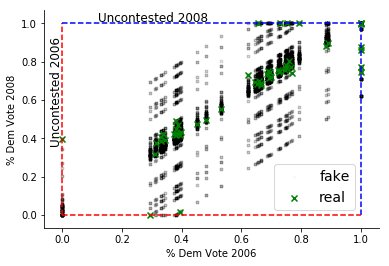

In [14]:
for i,sim in enumerate(simulations):
    plt.scatter(ca08.vote_share__prev, sim, 
                marker='.', color='k', alpha=.01,
                label='fake' if i == 0 else None)
plt.scatter(ca08.vote_share__prev, ca08.vote_share, 
            marker='x', color='green', label='real')
plt.vlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.hlines((0,1),0,1, linestyle='--', color=('r','b'))
plt.annotate('Uncontested 2006', 
             (-.04,.88), rotation=90, 
             fontsize=12)
plt.annotate('Uncontested 2008', 
             (.12,1.01), rotation=0, 
             fontsize=12)
plt.xlabel('% Dem Vote 2006')
plt.ylabel('% Dem Vote 2008')
seaborn.despine(ax=plt.gca())
plt.legend(loc='lower right', fontsize=14, bbox_to_anchor = (.95, .05))

Likewise, we can visualize the *full distribution* of district-level vote shares in the simulations and compare them to the observed election:

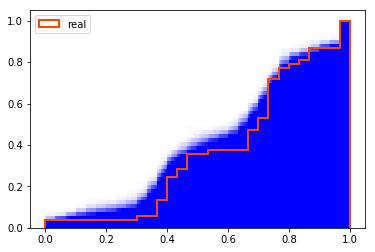

In [15]:
f,ax = plt.subplots(1,1)
[ax.hist(sim, histtype='stepfilled', 
         color='b', alpha=.01, bins=30, 
         density=True, cumulative=True)
 for sim in simulations]
ax.hist(ca08.vote_share, histtype='step', 
        color='orangered', bins=30, density=True, 
        linewidth=2, cumulative=True, label='real')
plt.legend()
plt.show()

We see that, in general, the simulated elections tend to be slightly more competitive, and (in general) are close to the observed results. But, it is helpful to note that they are slightly more Republican than the observed vote (on average). 

Further, using our simulations we can make the seats-votes plot for the observed election and a simulated election using the technique we discussed in the last chapter:

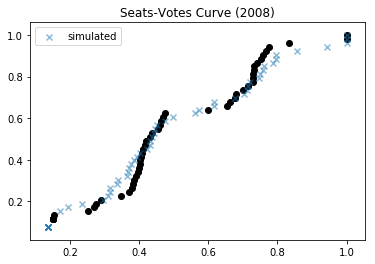

In [16]:
f,ax = svca.plot_empirical_seatsvotes(year=2008)
shift = .5 - simulations[0].mean()
ax.scatter(numpy.clip(1-simulations[0] - shift, 0,1),
           stats.rankdata(1-simulations[0])/53,
           marker='x', alpha=.5, label='simulated')
ax.legend()

Doing this for many of the elections, we can construct a *simulation envelope* around the observed elections, which is simply the seats-votes curve we did observe plotted on top of the seats-votes curves we build from all of the fake/simulated elections:

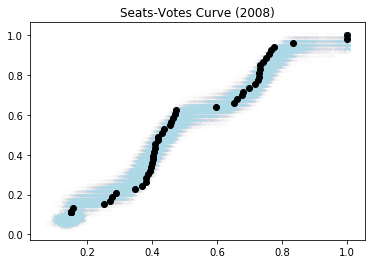

In [17]:
f,ax = svca.plot_empirical_seatsvotes(year=2008)
for i,sim in enumerate(simulations):
    shift = .5 - sim.mean()
    ax.scatter(numpy.clip(1-sim - shift, 0,1),
               stats.rankdata(1-sim)/53,
               marker='x', alpha=.01, color='lightblue', 
               zorder=-1)

Zooming in to see how this looks, we get something similar to the plots we saw above: because the simulations are locked into specific changes due to the bootstrapping in the swing vector, we can only occupy specific slots in the vote share and seat share set. However, since there are many seats and many replications, there are in fact many combinations of seat-shares and vote-shares that are deemed feasible to realize in this bootstrapping setup:

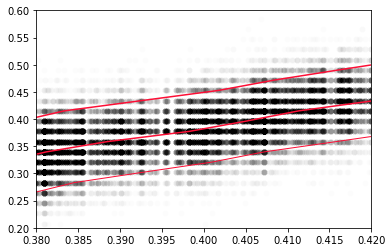

In [22]:
f,ax = svca.plot_simulated_seatsvotes(year=2008, n_sims=10000)
ax.set_ylim([.2, .6])
ax.set_xlim([.38,.42])
plt.show()

The red lines show the middle 95% of simulations, with the median simulation shown in the center line. Thus, out of all the simulations and fake elections we make, when Democrats have a 40% average district vote share, they tend to win somewhere between 29% and 41% of the congressional Delegation in California (with a median of about 36% of the delegation). Together, this allows us to examine many different measures of *electoral bias*; we can use the sets of simulations and the shape of this curve to build up expectations about the number of seats a party tends to win as a function of the number of votes it tends to recieve. 

# Conclusion

Seats-votes models sit at the heart of all electoral bias measures used currently. Either implicitly or explicitly, a seats-votes model allows us to assess the structure of the relationship between seats and votes in an electoral system. But, elections are *stochastic processes*, and collections of random events can combine together to make unexpected, surprising, or impossible-to-predict outcomes. In general, we handle this uncertainty and randomness using *simulation*; this lets us build up an *estimate* of the seats-votes curve both from what we *did* observe and then from elections we simulate that we believe are somewhat representative of things that could have happened if things were slightly different. 

There are many ways of constructing electoral simulators, and coming up with reasonable hypotheses about what randomness is relevant to which seats or elections. In the following chapters, I'll detail how many simulators work, and discuss how they're used in the new `seatsvotes` library for python. 

Beyond this, recall that nearly any electoral bias measure explicitly or implicitly refers to these seats-votes curves for their properties, measurement, and meaning. Thus, by adding uncertainty to our seats-votes estimates, we get uncertainty about our bias measures for free. This is important, since the *observed* election outcomes do not always tell the full story about how strong bias is in a city, state, or country. 